In [4]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
#import pandas

Using TensorFlow backend.


In [5]:
t=time.time()
train_data = np.array(list(np.loadtxt("train.csv", delimiter=","))).astype("float32")
train_labels = np.array(list(np.loadtxt("train_label.csv", delimiter=","))).astype("float32")
eval_data = np.array(list(np.loadtxt("eval.csv", delimiter=","))).astype("float32")
eval_labels = np.array(list(np.loadtxt("eval_label.csv", delimiter=","))).astype("float32")

#eval_data = pandas.read_csv("eval.csv", delimiter=",",header=None,dtype='float32')
#eval_labels = pandas.read_csv("eval_label.csv", delimiter=",",header=None,dtype='float32')
print(time.time()-t)

194.1680920124054


In [6]:
t=time.time()
test_data = np.array(list(np.loadtxt("H2_CG.csv", delimiter=","))).astype("float32")
test_labels = np.array(list(np.loadtxt("H2CG_label.csv", delimiter=","))).astype("float32")
print(time.time()-t)

1.9104788303375244


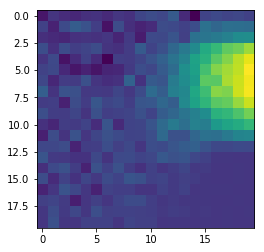

0.8348895
1.0 0.9973831 1.0497917
(64000,) (64000, 24, 24, 1)


In [13]:
x_train = np.reshape(train_data.reshape(-1, 24,24,3)[:,:,:,2],(-1,24,24,1))
x_val = np.reshape(eval_data.reshape(-1, 24,24,3)[:,:,:,2],(-1,24,24,1))
x_test = np.reshape(test_data.reshape(-1, 24,24,3)[:,:,:,2],(-1,24,24,1))

y_train=np.abs(np.reshape(train_labels,(-1,4))[:,0])
y_val=np.abs(np.reshape(eval_labels,(-1,4))[:,0])
y_test=np.abs(np.reshape(test_labels,(-1,4))[:,0])

plt.imshow(-np.reshape(test_labels,(20,20,4))[:,:,0])
plt.show()
y_max=max(np.max(y_train),np.max(y_val))  #maximum observed chirality
y_train=y_train/y_max
y_val=y_val/y_max
y_test=y_test/y_max
print(y_max)
print(np.amax(y_train,axis=0),np.amax(y_val,axis=0),np.amax(y_test,axis=0))
print(np.shape(y_train),np.shape(x_train))

In [14]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (6, 6), activation='relu', input_shape = (24, 24, 1)))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4))#, metrics=["accuracy"]) #binary_crossentropy

In [16]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [17]:
hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val, y_val), #For speed
                           callbacks=[annealer])

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
 - 52s - loss: 0.0300 - val_loss: 0.0100
Epoch 2/10
 - 49s - loss: 0.0060 - val_loss: 0.0068
Epoch 3/10
 - 50s - loss: 0.0050 - val_loss: 0.0060
Epoch 4/10
 - 51s - loss: 0.0045 - val_loss: 0.0046
Epoch 5/10
 - 51s - loss: 0.0043 - val_loss: 0.0042
Epoch 6/10
 - 50s - loss: 0.0041 - val_loss: 0.0043
Epoch 7/10
 - 49s - loss: 0.0040 - val_loss: 0.0036
Epoch 8/10
 - 50s - loss: 0.0038 - val_loss: 0.0047
Epoch 9/10
 - 50s - loss: 0.0038 - val_loss: 0.0036
Epoch 10/10
 - 50s - loss: 0.0037 - val_loss: 0.0034


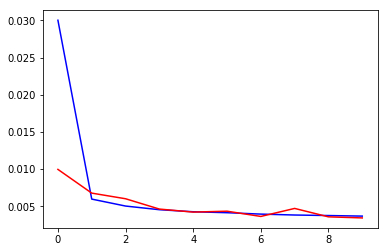

In [18]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [19]:
y_hat = model.predict(x_val)

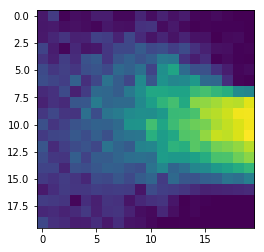

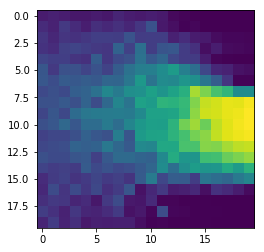

(20, 20, 40, 1)


In [22]:
y_val=np.reshape(y_val,(20,20,40,1))
y_hat=np.reshape(y_hat,(20,20,40,1))

plt.imshow(y_val[:,:,20,0])
plt.show()
plt.imshow(y_hat[:,:,20,0])
plt.show()

print(np.shape(y_hat))

In [23]:
y_hat = model.predict(x_test)

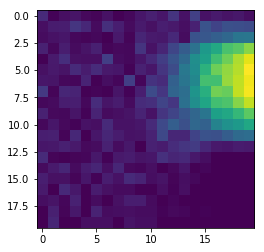

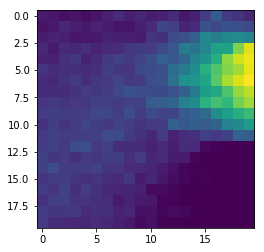

(20, 20, 1)


In [27]:
#y_test=np.abs(np.reshape(test_labels,(-1,1)))
#y_test[:,0]=y_test[:,0]/(-np.max(y_test[:,0]))
#print(np.min(y_test[:,0]))
y_test=np.reshape(y_test,(20,20,1))
y_hat=np.reshape(y_hat,(20,20,1))

plt.imshow(y_test[:,:,0])
plt.show()
plt.imshow(y_hat[:,:,0])
plt.show()

print(np.shape(y_hat))

In [28]:
(np.sum(np.sum((y_test-y_hat)**2,axis=0),axis=0)/(20*20))**0.5

array([0.08908986], dtype=float32)

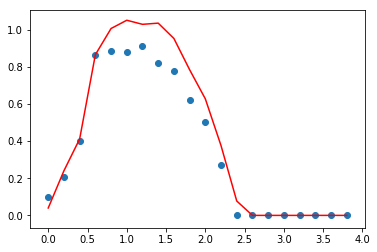

In [29]:
x=np.arange(0,4,4/20)
plt.plot(x,y_test[:,19,0],'r')
plt.scatter(x,y_hat[:,19,0])
plt.show()

In [30]:
W=model.get_weights()

In [62]:
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    print(h)
    print(np.shape(h))

[array([[[[ 0.06240646,  0.03229678, -0.03197146, -0.07140452,
           0.07266533, -0.04007619, -0.06026345, -0.0952403 ,
          -0.06856129,  0.0190424 , -0.05806315, -0.05909342,
           0.0693726 ,  0.04725202,  0.02324051,  0.02279167]],

        [[-0.02811314,  0.0455635 , -0.06523362,  0.06039633,
           0.01908719, -0.00755744, -0.06733727,  0.03326623,
          -0.046634  , -0.03273576, -0.01805887, -0.00268257,
          -0.07685103, -0.06676991, -0.05469632,  0.12314866]],

        [[ 0.02937217,  0.04197767,  0.03270744,  0.09934472,
          -0.05398378, -0.06097063, -0.05371949, -0.04045386,
           0.09040833, -0.10777238,  0.08974834,  0.06470755,
          -0.0990961 ,  0.02920263,  0.05776115,  0.0143366 ]],

        [[ 0.0508333 , -0.0155917 ,  0.03678424,  0.05452124,
          -0.02385889,  0.02701816, -0.09153892, -0.04832444,
           0.08304991, -0.10107321, -0.05681577,  0.01058553,
          -0.05267176,  0.08128213,  0.01423527,  0.07204849

[]
(0,)
[array([[ 0.03805399,  0.02346267, -0.01332445, ..., -0.03918891,
         0.04856205, -0.07195118],
       [ 0.06975166, -0.04917312, -0.00071267, ..., -0.01228383,
         0.00853449,  0.0803101 ],
       [-0.02677287, -0.00867067,  0.01775154, ...,  0.05579391,
         0.02601349, -0.0486278 ],
       ...,
       [ 0.0542977 , -0.01122275,  0.00011868, ...,  0.05208619,
        -0.04493332,  0.03060645],
       [-0.0331379 ,  0.06068019, -0.09164044, ...,  0.03055351,
         0.06386032, -0.09719546],
       [-0.0079781 , -0.00490374, -0.06142848, ...,  0.07380643,
        -0.01126761, -0.0462146 ]], dtype=float32), array([ 1.08389081e-02, -2.53703278e-02, -4.85316763e-04,  6.41726237e-03,
       -1.60203837e-02,  1.63093826e-03,  1.18190004e-02, -2.23403499e-02,
       -3.53058078e-03, -4.70982166e-03, -6.13564998e-03,  1.42245432e-02,
        2.30221078e-03,  4.18809801e-03, -2.07580049e-02, -1.58708896e-02,
        7.80515373e-03, -6.45068195e-03, -9.47804842e-03, -9.5

(1024,)


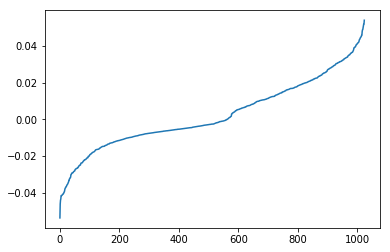

In [89]:
Wt=np.array(h)[0][:,0]
print(np.shape(Wt))
plt.plot(np.sort(Wt))

In [32]:
for i in range(18):
    print(np.shape(W[i]))

(6, 6, 1, 16)
(16,)
(16,)
(16,)
(16,)
(16,)
(3, 3, 16, 32)
(32,)
(32,)
(32,)
(32,)
(32,)
(288, 512)
(512,)
(512, 1024)
(1024,)
(1024, 1)
(1,)


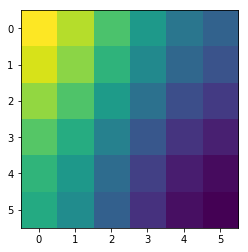

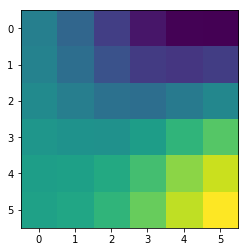

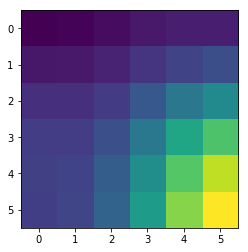

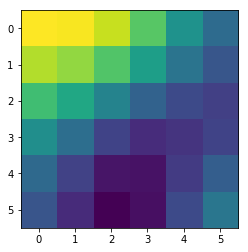

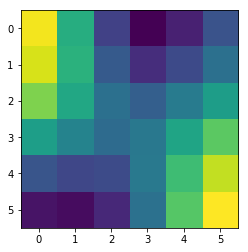

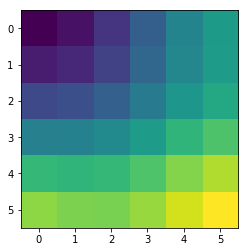

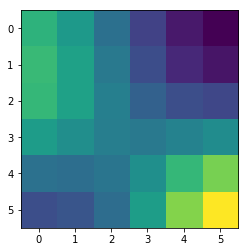

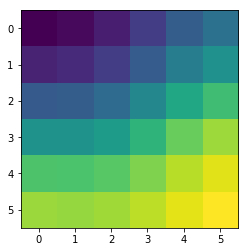

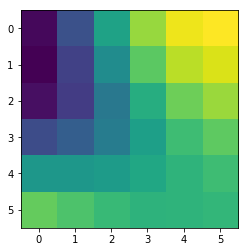

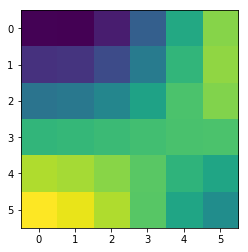

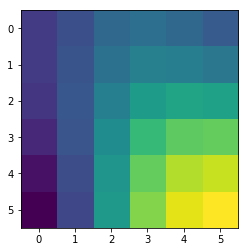

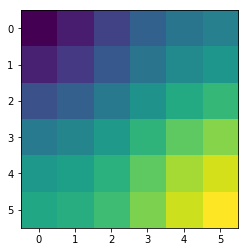

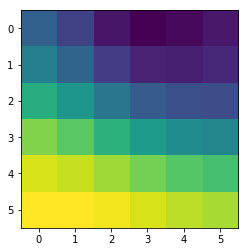

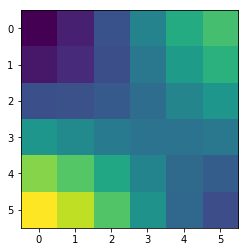

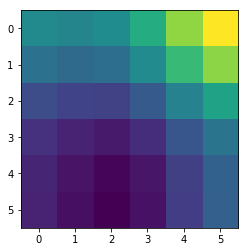

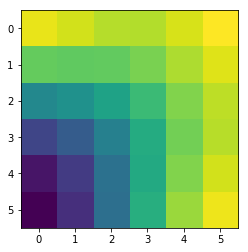

In [109]:
from scipy.ndimage import gaussian_filter

for i in range(16):
    plt.imshow(gaussian_filter(np.array(W[0])[:,:,0,i],2))
    plt.show()

In [33]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

In [34]:
print(K.learning_phase())
for i in range(16):
    print(outputs[i])

Tensor("batch_normalization_1/keras_learning_phase:0", shape=(), dtype=bool)
Tensor("conv2d_4/Relu:0", shape=(?, 19, 19, 16), dtype=float32)
Tensor("batch_normalization_3/cond/Merge:0", shape=(?, 19, 19, 16), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("dropout_5/cond/Merge:0", shape=(?, 9, 9, 16), dtype=float32)
Tensor("conv2d_5/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("batch_normalization_4/cond/Merge:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("dropout_6/cond/Merge:0", shape=(?, 3, 3, 32), dtype=float32)
Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dense_4/BiasAdd:0", shape=(?, 512), dtype=float32)
Tensor("leaky_re_lu_3/LeakyRelu:0", shape=(?, 512), dtype=float32)
Tensor("dropout_7/cond/Merge:0", shape=(?, 512), dtype=float32)
Tensor("dense_5/BiasAdd:0", shape=(?, 1024), dtype=float32)
Tensor("leaky_re_lu_4/LeakyRelu:0", shape=

In [58]:
# Testing
#test = x_test[19,:,:,:][np.newaxis,...]
#test=np.ones((1,24,24,1))
test=np.random.rand(1,24,24,1)
layer_outs = [func([test, 0]) for func in functors]
print(layer_outs)

[[array([[[[0.        , 0.        , 0.3261722 , ..., 0.        ,
          0.        , 0.3655062 ],
         [0.        , 0.04492711, 0.3173098 , ..., 0.        ,
          0.        , 0.5065274 ],
         [0.12768258, 0.        , 0.358201  , ..., 0.        ,
          0.        , 0.2571577 ],
         ...,
         [0.        , 0.03745499, 0.26148602, ..., 0.        ,
          0.        , 0.4050953 ],
         [0.04604702, 0.14102207, 0.4115413 , ..., 0.        ,
          0.        , 0.3250571 ],
         [0.10755493, 0.17987305, 0.3201658 , ..., 0.        ,
          0.        , 0.42510363]],

        [[0.        , 0.09947394, 0.23645608, ..., 0.        ,
          0.        , 0.43735558],
         [0.23017631, 0.02131294, 0.26163256, ..., 0.06980277,
          0.00059973, 0.45373762],
         [0.        , 0.        , 0.4096917 , ..., 0.        ,
          0.01001651, 0.29154825],
         ...,
         [0.        , 0.09607294, 0.29016787, ..., 0.        ,
          0.        , 0

In [59]:
for i in range(16):
    print(np.shape(layer_outs[i]))

(1, 1, 19, 19, 16)
(1, 1, 19, 19, 16)
(1, 1, 9, 9, 16)
(1, 1, 9, 9, 16)
(1, 1, 7, 7, 32)
(1, 1, 7, 7, 32)
(1, 1, 3, 3, 32)
(1, 1, 3, 3, 32)
(1, 1, 288)
(1, 1, 512)
(1, 1, 512)
(1, 1, 512)
(1, 1, 1024)
(1, 1, 1024)
(1, 1, 1024)
(1, 1, 1)


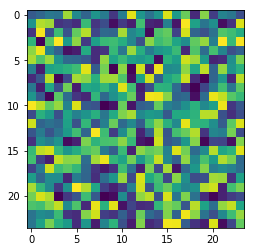

(1, 1, 19, 19, 16)


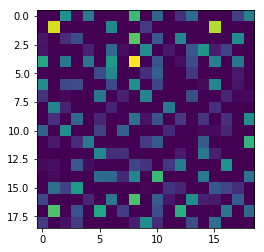

(1, 1, 19, 19, 16)


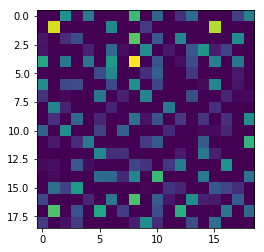

(1, 1, 9, 9, 16)


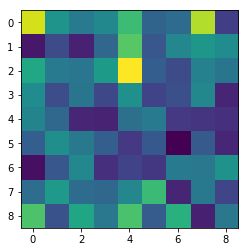

(1, 1, 9, 9, 16)


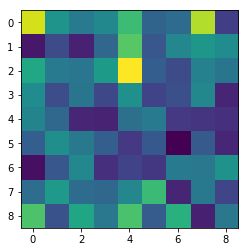

(1, 1, 7, 7, 32)


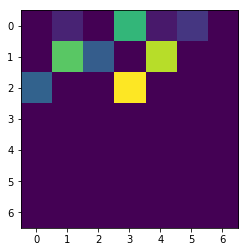

(1, 1, 7, 7, 32)


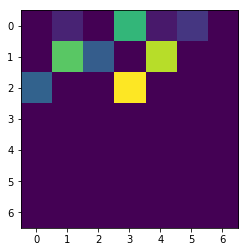

(1, 1, 3, 3, 32)


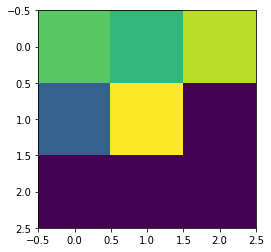

(1, 1, 3, 3, 32)


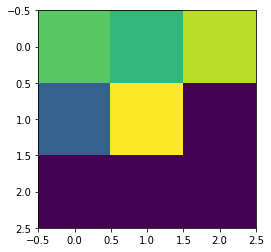

In [60]:
plt.imshow(test[0,:,:,0])
plt.show()
for i in range(8):
    print(np.shape(layer_outs[i]))
    plt.imshow(np.array(layer_outs[i])[0,0,:,:,0])
    plt.show()

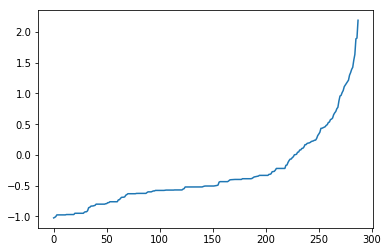

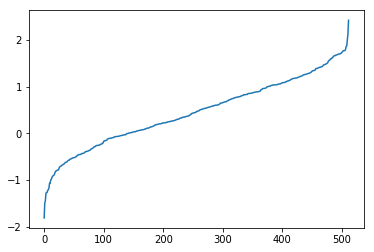

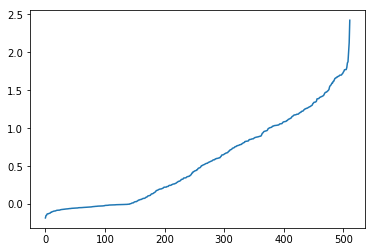

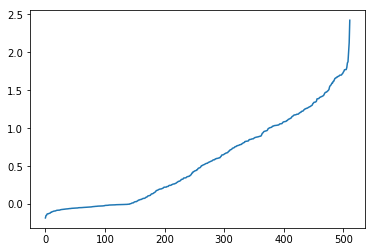

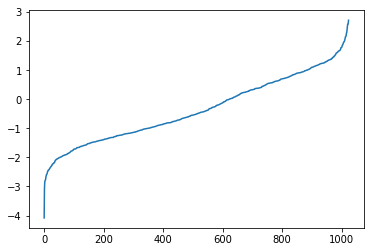

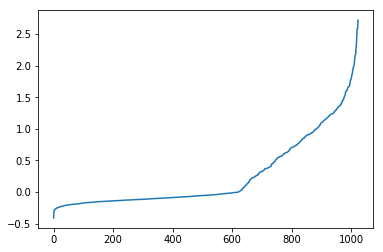

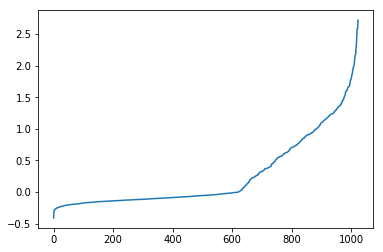

[0.00881133]


In [61]:
for i in range(8,15):
    plt.plot(np.sort(np.array(layer_outs[i])[0,0,:]))
    plt.show()
print(np.array(layer_outs[15])[0,0,:])